In [1]:
import geopandas as gpd
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import cm as cm
import matplotlib.colors as mcolors

In [2]:
nyc_blocks = gpd.read_file("https://data.cityofnewyork.us/resource/wmsu-5muw.geojson?$limit=1000000").to_crs(2263)
nyc_blocks['geometry'] = nyc_blocks['geometry'].centroid
nyc_blocks.shape

(37588, 9)

In [3]:
nyc_blocks

,shape_area,shape_leng,boroname,ct2020,borocode,cb2020,bctcb2020,geoid,geometry
0,1202838.17013,6437.85374521,Manhattan,000100,1,1000,10001001000,360610001001000,POINT (972944.677 193858.647)
1,640166.352288,4395.19018343,Manhattan,000100,1,1001,10001001001,360610001001001,POINT (971690.782 190614.532)
2,129276.332277,1569.3848232,Manhattan,000201,1,1000,10002011000,360610002011000,POINT (988073.020 199422.877)
3,139360.445114,1594.26285534,Manhattan,000201,1,1001,10002011001,360610002011001,POINT (988120.432 199170.586)
4,263308.43936,2055.29596105,Manhattan,000201,1,2000,10002012000,360610002012000,POINT (988160.842 198788.669)
...,...,...,...,...,...,...,...,...,...
37583,55396.4451445,1888.37802549,Manhattan,023700,1,3004,10237003004,360610237003004,POINT (998209.020 242167.180)
37584,368325.466887,5101.30894471,Bronx,046203,2,3007,20462033007,360050462033007,POINT (1031823.604 260801.524)
37585,121907.352158,4716.0641206,Bronx,046203,2,3010,20462033010,360050462033010,POINT (1031519.295 260732.179)
37586,107292.76798,1478.93979656,Queens,067900,4,1001,40679001001,360810679001001,POINT (1019805.268 204379.751)


In [4]:
# load all boundaries
gdf_boundaries = gpd.read_file("../../nyc-geography-crosswalks/data/processed/all_boundaries.geojson").to_crs(2263)

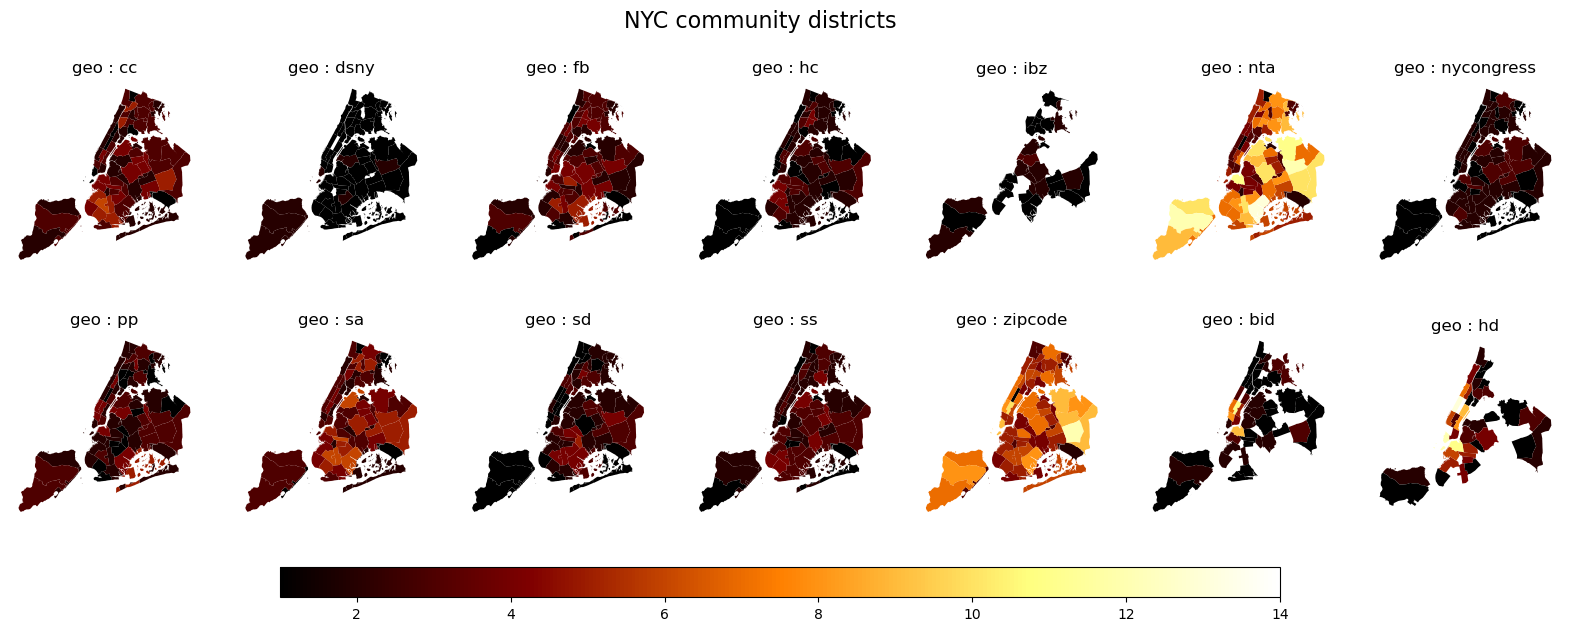

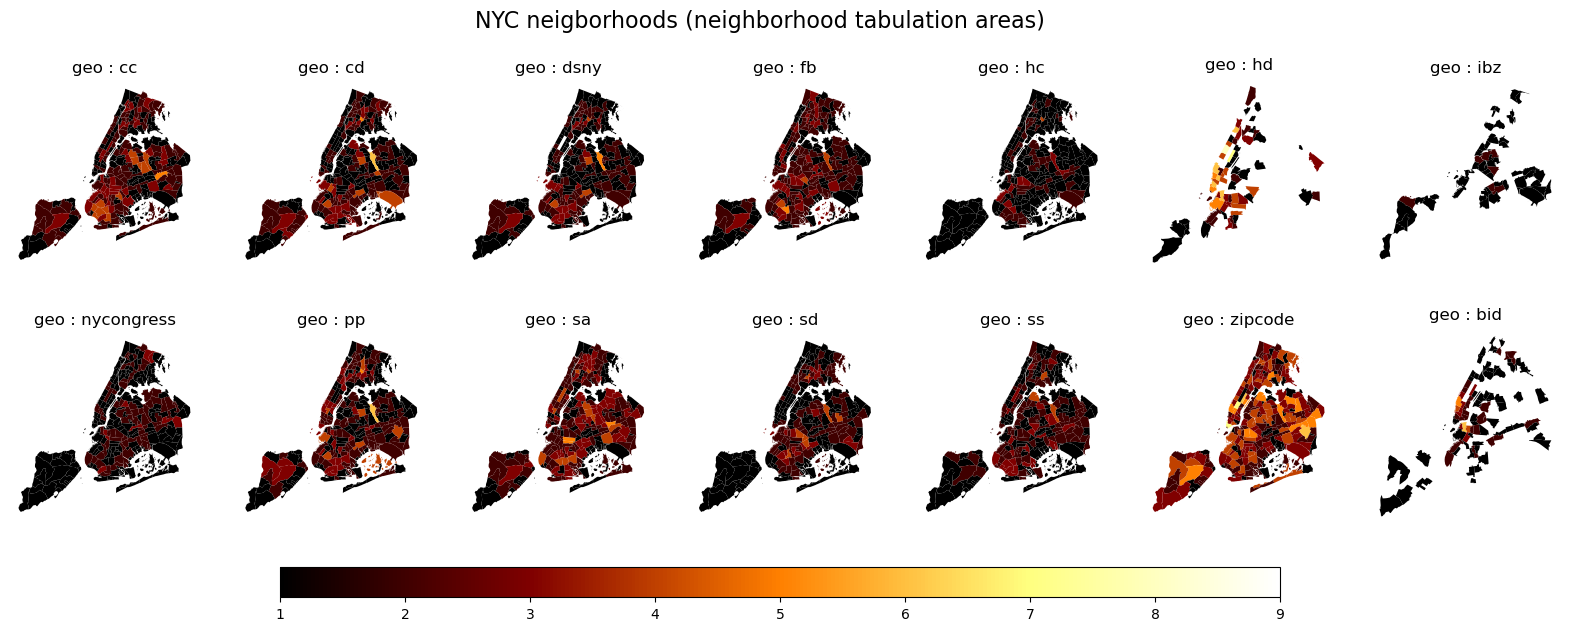

In [5]:
for primary_type in ['cd', 'nta']:
    # load crosswalks
    df_cd_xwalk = pd.read_csv(f"../../nyc-geography-crosswalks/outputs/2025-12-02_180619_UTC/longform/longform_{primary_type}_crosswalk.csv")
    df_cd_xwalk['Primary Geography NameCol'] = df_cd_xwalk['Primary Geography NameCol'].astype(str)

    gdf_cd = gpd.read_file(f"../../nyc-geography-crosswalks/data/processed/{primary_type}.geojson")
    gdf_cd['nameCol'] = gdf_cd['nameCol'].astype(str)
    gdf_cd.head()

    gdf_cd_mgd = gdf_cd.merge(df_cd_xwalk.groupby(['Primary Geography ID', 'Primary Geography NameCol', 'Other Geography ID'], as_index=False)['Other Geography NameCol'].count(), how='left', left_on='nameCol', right_on='Primary Geography NameCol')

    fig, axes = plt.subplots(2,7, figsize=(20,6))
    axes = axes.flatten()
    for i, gdf_type in enumerate(gdf_cd_mgd['Other Geography ID'].unique()):
        gdf_cd_mgd[gdf_cd_mgd['Other Geography ID']==gdf_type].plot(ax=axes[i], column='Other Geography NameCol', cmap='afmhot', vmin=1, vmax=gdf_cd_mgd['Other Geography NameCol'].max())
        axes[i].set_title(f'geo : {gdf_type}')
        axes[i].set_axis_off()

    mappable = cm.ScalarMappable(
        norm=mcolors.Normalize(1, gdf_cd_mgd['Other Geography NameCol'].max()),
        cmap='afmhot'
    )
    cb_ax = fig.add_axes([0.26, 0, 0.5, 0.05])

    # draw colorbar
    cbar = fig.colorbar(mappable, cax=cb_ax, orientation='horizontal')

    if primary_type == 'cd':
        fig.suptitle(f'NYC community districts', fontsize=16)
    else:
        fig.suptitle(f'NYC neigborhoods (neighborhood tabulation areas)', fontsize=16)

    plt.savefig(f"{primary_type}.png", bbox_inches='tight', dpi=300)
